In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils, datasets
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from skimage import io
from PIL import Image

In [2]:
EPOCH = 30                # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 12
INPUT_SIZE = 227         # img input size
LR = 0.001               # learning rate
DOWNLOAD_MNIST = False   # set to True if haven't download the data
TEST = False

In [3]:
class GroceryDataset(Dataset):
    data_transform = transforms.Compose([
        transforms.Resize(227),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    """Frocery dataset."""
    def __init__(self, mode = 'train', file = 0, \
                 transform = data_transform):
        self.fpath = '/hostname/freiburg_groceries_dataset/'
        if mode == 'train':
            file_path = self.fpath + 'splits/train{}.txt'.format(file)
            print('Training file: ', file_path)
        elif mode == 'test':
            file_path = self.fpath + 'splits/test{}.txt'.format(file)
            print('Testing file: ', file_path)
        self.filepath = os.path.join(self.fpath)
        with open(file_path) as f:
            self.flines = f.readlines()
        self.length = len(self.flines)
        self.transform = transform

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        #fsplit = self.flines[idx].split('/')
        #print fsplit[1], fsplit[2]
        label = torch.tensor(int(self.flines[idx].split(' ')[-1]))
        #label = torch.tensor(self.cls.index(fsplit[1]))
        #label = fsplit[1]
        image_path = self.fpath + 'images/' + self.flines[idx].split(' ')[0:-1][0].strip()
        img = self.transform(Image.open(image_path))
        #item = {'image': img, 'landmarks': label}
        return img, label

In [4]:
class CaffeNet(nn.Module):
    def __init__(self):
        super(CaffeNet, self).__init__()
        '''self.pool2x2 = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 16, 5, 1, 2)
        self.conv2 = nn.Conv2d(1, 16, 5, 1, 2)
        self.fc1 = nn.Linear(16*5*5, 120)'''
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 96, 11, 4, 0), #in, out, kernel, stride, padding
            nn.ReLU(),
            nn.MaxPool2d((3, 3), 2), #kernel size, stride
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(96, 256, 5, 1, 2), #in, out, kernel, stride, padding
            nn.ReLU(),
            nn.MaxPool2d(3, 2), #kernel size, stride
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 384, 3, 1, 1), #in, out, kernel, stride, padding
            nn.ReLU(),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 384, 3, 1, 1), #in, out, kernel, stride, padding
            nn.ReLU(),
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(384, 256, 3, 1, 1), #in, out, kernel, stride, padding
            nn.ReLU(),
            nn.MaxPool2d(3, 2), #kernel size, stride
        )
        self.fc6 = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout2d(0.5)
        )
        self.fc7 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout2d(0.5)
        )
        self.out = nn.Linear(4096, 25)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(-1, 256*6*6) #flatten data
        x = self.fc6(x)
        x = self.fc7(x)
        output = self.out(x)
        return output

In [5]:
def load_mnist_data(bt = BATCH_SIZE, fpath = '/home/arg_ws3/mnist'):
    data_transform = transforms.Compose([
            transforms.Resize(227),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ])
    train_data = torchvision.datasets.MNIST(
        root = fpath,
        train = True, # this is training data
        transform = data_transform
    )
    train_loader = torch.utils.data.DataLoader(dataset = train_data, \
                                               batch_size = bt, \
                                               shuffle = True)
    return train_loader

In [6]:
def load_grocery_data(bt = BATCH_SIZE, mode = 'train', \
                      fpath = '/hostname/freiburg_groceries_dataset/images'):
    data_transform = transforms.Compose([
            transforms.Resize(227),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ])
    train_data = datasets.ImageFolder(root = fpath, \
                                           transform = data_transform)
    train_data = GroceryDataset(mode = mode)
    train_loader = torch.utils.data.DataLoader(dataset = train_data, \
                                                 batch_size = bt, \
                                                 shuffle = True)
    return train_loader

In [7]:
def load_test_data(bt = 1, dataset = 'grocery'):
    if dataset == 'grocery':
        test_loader = load_grocery_data(bt = bt, mode = 'test')
    elif dataset == 'mnist':
        test_loader = load_mnist_data(bt = bt)
    data_iter = iter(test_loader)
    return data_iter

In [8]:
def vis_img(data):
    img = data[0][0].cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    print (img.shape)
    img = cv2.resize(img, (227, 227)) 
    print (img.shape)
    plt.imshow(img, cmap='gray')
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=0)
    img = torch.from_numpy(img).cuda()

In [9]:
def test_caffenet(weight_file = '29'):
    weight_path = '/hostname/freiburg_groceries_dataset/pytorch_model/net_{}.pth'.format(weight_file)
    data_iter = load_test_data(dataset = 'grocery')
    #Define model
    print('Load training model')
    caffenet = torch.load(weight_path).cuda()
    data = next(data_iter)
    outputs = caffenet(data[0].cuda())
    pred_y = torch.max(outputs, 1)[1].cpu().numpy()
    print ('Prediction: ', pred_y)
    print ('Ground truth: ', data[1].cpu().numpy())
    vis_img(data)

In [10]:
def train_caffenet():
    #Define training data
    train_loader = load_grocery_data()
    #Define model, optimizer and loss function
    print('Load training model')
    caffenet = CaffeNet().cuda()
    print (caffenet)
    #optimizer = torch.optim.Adam(caffenet.parameters(), lr = LR)   # optimize all cnn parameters
    optimizer = torch.optim.SGD(caffenet.parameters(), lr = LR, momentum=0.9, weight_decay=0.0005)
    loss_func = nn.CrossEntropyLoss().cuda()
    
    running_loss = 0.
    cnt = 0
    for epoch in range(EPOCH):
        print('========== Epoch: ', epoch, ' ==========')
        for step, data in enumerate(train_loader):
            cnt = cnt + 1
            imgs = data[0].cuda()
            labels = data[1].cuda()
            optimizer.zero_grad()
            outputs = caffenet(imgs)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            if cnt % 50 == 0:
                print ('loss: ', loss.item())
        model_name = '/hostname/freiburg_groceries_dataset/pytorch_model/net_{}.pth'.format(epoch)
        torch.save(caffenet, model_name)
        print('----- Save model: {} -----'.format(model_name))
    print('Finish Training')

In [26]:
train_caffenet()

Training file:  /hostname/freiburg_groceries_dataset/
Load training model
CaffeNet(
  (conv1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv5): Sequential(
    (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc6): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bia

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CaffeNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


----- Save model: /hostname/freiburg_groceries_dataset/pytorch_model/net_0.pth -----
========== Epoch:  1  ==========
loss:  3.2190768718719482
loss:  3.219616651535034
loss:  3.2148828506469727
loss:  3.219959020614624
loss:  3.215876340866089
loss:  3.2126495838165283
loss:  3.2123334407806396
loss:  3.2239410877227783
loss:  3.123762845993042
loss:  3.264995813369751
loss:  2.9349193572998047
loss:  3.1478793621063232
----- Save model: /hostname/freiburg_groceries_dataset/pytorch_model/net_1.pth -----
========== Epoch:  2  ==========
loss:  3.1658191680908203
loss:  3.0362441539764404
loss:  3.0750205516815186
loss:  3.246497869491577
loss:  3.0360910892486572
loss:  3.0036051273345947
loss:  2.975402593612671
loss:  3.0150959491729736
loss:  2.7714834213256836
loss:  3.2129781246185303
loss:  3.0686912536621094
loss:  2.961627244949341
loss:  2.787688970565796
----- Save model: /hostname/freiburg_groceries_dataset/pytorch_model/net_2.pth -----
========== Epoch:  3  ==========
loss:

loss:  0.04341777041554451
loss:  0.009458859451115131
loss:  0.029032787308096886
loss:  0.013034582138061523
loss:  0.5187526345252991
loss:  0.030622243881225586
loss:  0.017828306183218956
----- Save model: /hostname/freiburg_groceries_dataset/pytorch_model/net_19.pth -----
========== Epoch:  20  ==========
loss:  0.017703771591186523
loss:  0.028121789917349815
loss:  0.053481657058000565
loss:  0.30169788002967834
loss:  0.0006798903341405094
loss:  0.6617201566696167
loss:  0.02460646629333496
loss:  0.0019404888153076172
loss:  0.002541065216064453
loss:  0.012075264938175678
loss:  0.011993408203125
loss:  0.005792299751192331
----- Save model: /hostname/freiburg_groceries_dataset/pytorch_model/net_20.pth -----
========== Epoch:  21  ==========
loss:  0.3043340742588043
loss:  0.12584860622882843
loss:  0.010586023330688477
loss:  0.12126227468252182
loss:  0.8541598320007324
loss:  0.02026490308344364
loss:  0.07952459901571274
loss:  0.0008176167611964047
loss:  0.1108755245

Testing file:  /hostname/freiburg_groceries_dataset/splits/test0.txt
Load training model


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction:  [8]
Ground truth:  [8]
(227, 227, 3)
(227, 227, 3)


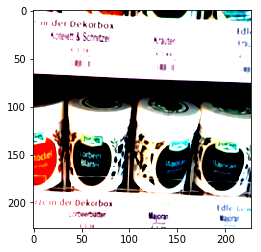

In [11]:
test_caffenet(24)